# Variational Autoencoder Data: pianoroll
## CVAE  using trained model for generating mus examples


In [1]:
!pip install muspy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 35.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.5 MB/s eta 0:00:00
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=755338a25c9d7998df9f6a8f2de1268cbbd6fd749708c545e45f24029539c02e
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty-midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model, Input
import matplotlib.pyplot as plt
import muspy
import pypianoroll
import pretty_midi
from keras.utils import  to_categorical
from keras.optimizers import Adam
print ('muspy ver ' , muspy.__version__ )

from numpy import load
import time
import sys
import os
import random

tf.random.set_seed(27)
os.environ['PYTHONHASHSEED'] = str(27)
np.random.seed(27)
random.seed(27)

print("TF ver:",tf.__version__)
#import keras
print("Keras ver:", keras.__version__)

muspy ver  0.5.0
TF ver: 2.17.0
Keras ver: 3.4.1


## Khởi tạo tham số và dữ liệu

In [3]:
MODEL_CONFIG = {
    'num_timestep': 64,
    'num_pitch': 60, # 31, 60

    'num_labels': 4,

    'vae_type': 'vae',  # 'sigma-vae'

    'batch_size': 8,  # 4, 8, 16
    'latent_dim': 32, # 20, 32


    'track_names': (
        'All',
    ),
    # Samples  # number of genarating samples
    'num_sample': 10,

     # Metrics
    'metric_map': np.array([
        # indices of tracks for the metrics to compute
        [True] * 8,  # empty bar rate
        [True] * 8,  # number of pitch used

    ], dtype=bool),

    'scale_mask_Cmajor': list(map(bool, [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1])),
    'scale_mask_Cminor': list(map(bool, [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1])),

    'result_dir': '../content/gen/',
    'run_main_program': False,

    # Directories
    'checkpoint_dir': None,
    'sample_dir': None,
    'eval_dir': None,
    'log_dir': None,
    'src_dir': None,

    'verbose_print_summary': False,
    }

In [12]:
DATA_CONFIG = {
    'training_data': '/content/final_tensor_325.npz',
}

SETUP = {
    'exp_name': None,
    # nazwa eksperymentu

    # 'training_data': './training_data/my_piano_rep_358.npz',   # data bez labeling
    'training_data': '/content/final_tensor_325.npz',
    # Plik z danymi treningowymi

    'prefix': 'Woww',
    # 'jacekbachdata' "jacekbachdata_80_20"  "jacekbachdata_oldData"  'jacekbachdata_oldData_GenBN'
    # Prefix for the experiment name. Useful when training with different
    # training data to avoid replacing the previous experiment outputs.

    'training_phase': 'train',
    # {'train', 'pretrain'}

    'preset_enc': 'proposed_3',
    # {'proposed', 'proposed_2',  'proposed_small', None}


    'preset_dec': 'proposed_3',
    # {'proposed',  'proposed_2','proposed_small', 'ablated', 'baseline', None}

    }
TRAIN_CONFIG = {
    'num_epoch': 400,
    'evaluate_after_training': True ,
    # 'num_epochs': 500,  # Số lượng epoch bạn muốn huấn luyện
    'batch_size': 4,  # Kích thước batch
    'evaluate_along_training': True,  # Đánh giá trong quá trình huấn luyện hay không
    'save_interval': 10  # Lưu mô hình sau mỗi 10 epochs # Đảm bảo có khóa này
}


EXP_CONFIG = {
  'exp_name': None,

  }
EXP_CONFIG['exp_name'] = '_'.join(
                (SETUP['prefix'], SETUP['training_phase'], 'enc',
                 SETUP['preset_enc'], 'dec', SETUP['preset_dec'],
                 )
                )

In [5]:
def load_data():
    """Load and return the training data."""
    print('[*] Loading data...')
    dict_data = np.load(DATA_CONFIG['training_data'])

    # dict_data = load('../training_data/my_piano_rep_358.npz')
    train_X = dict_data['arr_0']
    print("train_X.shape", train_X.shape)
    train_X = np.reshape(train_X, (-1, MODEL_CONFIG['num_timestep'], MODEL_CONFIG['num_pitch'], 1))
    print("train_X.shape", train_X.shape)
    print('Training set size:', len(train_X))
    return train_X

In [6]:
def shuffle_data(train_X, train_y):
    ''' miesza dane train_X razem z etykietami train_y'''
    from sklearn.utils import shuffle
    print ("train_y: \n", train_y)
    train_X, train_y = shuffle(train_X, train_y, random_state=42)
    print ("train_y: \n", train_y)

    unique_elements, counts_elements = np.unique(train_y, return_counts=True)
    print("Frequency of unique values of the said array:")
    print(np.asarray((unique_elements, counts_elements)))

    return train_X, train_y

In [7]:
def load_data_emo():
    """Ładowanie danych z podziaĹ‚em oznaczonych emo"""
    print('[*] Loading data...')
    dict_data = np.load(DATA_CONFIG['training_data'])
    # print(dict_data.files)
    train_X = dict_data['arr_0']
    train_y = dict_data['arr_1']

    print("train_X.shape", train_X.shape)
    train_X = np.reshape(train_X, (-1, MODEL_CONFIG['num_timestep'], MODEL_CONFIG['num_pitch'], 1))

    print("train_X.shape", train_X.shape)
    print("train_y.shape", train_y.shape)
    train_X, train_y = shuffle_data(train_X, train_y)

    return train_X, train_y

In [8]:
def labels_to_categorical(train_y):
    # labels
    # print(train_y)
    # one-hot encoding
    train_y_onehot = to_categorical(train_y)

    print("train_y_onehot.shape: ", train_y_onehot.shape)
    print("train_y_onehot[0]: ", train_y_onehot[0])
    return train_y_onehot

In [9]:
# import sys; sys.path.insert(0, '..') # JGadd parent folder path where lib folder is Dodanie wyższej ścieżki do PATH
# from model.models import VAE, CVAE
# from config import MODEL_CONFIG, DATA_CONFIG, SETUP, TRAIN_CONFIG, EXP_CONFIG
# from utils.metrics import Metrics

DATA_CONFIG['training_data'] = SETUP['training_data']  # Sửa đường dẫn tệp
# train_X = load_data()
# train_X, test_X = load_data_train_test()
train_X, train_y =  load_data_emo() # """Ładowanie danych z podziałem oznaczonych emo"""
train_y_onehot = labels_to_categorical(train_y)

[*] Loading data...
train_X.shape (325, 64, 60, 1)
train_X.shape (325, 64, 60, 1)
train_y.shape (325,)
train_y: 
 [2 2 3 3 3 3 3 1 1 3 3 3 2 1 0 0 3 0 2 2 1 0 3 1 1 1 2 2 2 1 2 3 1 0 1 2 2
 1 3 1 3 3 3 2 2 3 1 2 1 2 2 3 3 2 3 2 3 2 1 3 2 3 2 0 1 3 1 1 3 1 3 3 2 3
 3 2 0 2 2 2 3 1 1 3 0 3 2 2 3 3 3 3 3 1 3 2 1 2 3 3 3 3 3 3 3 1 3 2 0 2 2
 0 3 2 0 1 2 3 0 1 0 2 1 0 0 3 3 3 1 1 1 1 1 0 0 1 1 2 0 3 1 3 3 0 0 2 2 2
 2 3 0 1 0 1 1 1 0 3 3 0 2 0 3 3 3 1 1 1 2 0 0 0 1 0 2 1 3 3 0 2 3 2 0 2 1
 2 0 0 2 1 2 2 2 1 1 1 3 0 1 0 1 0 3 0 3 1 1 2 1 3 0 1 0 0 3 2 1 0 0 3 3 0
 2 0 2 3 0 1 0 3 1 1 2 2 3 1 1 0 3 1 1 2 0 0 0 2 0 3 1 1 2 0 3 3 3 1 3 2 2
 2 2 1 0 3 3 2 1 3 2 1 3 3 3 1 3 2 1 2 0 1 1 2 1 3 3 1 0 0 0 3 1 3 2 1 2 2
 0 3 0 2 0 2 0 1 0 0 0 1 1 2 1 2 0 1 3 1 2 1 0 0 3 2 1 0 3]
train_y: 
 [3 2 1 3 1 3 0 1 0 3 2 1 1 3 3 1 2 0 1 3 1 2 1 1 3 2 0 0 0 3 0 1 1 3 2 1 2
 0 3 1 1 3 1 0 3 0 0 1 2 3 2 3 1 0 2 3 1 3 3 3 1 2 2 0 0 1 2 0 1 1 2 0 2 3
 1 1 0 2 3 2 1 3 3 2 3 2 3 1 3 3 3 3 2 3 0 2 3 1 2 3 1 1 1 3 3 0 

In [ ]:
np.set_printoptions(threshold=sys.maxsize)

In [10]:
print(train_X.shape)

(325, 64, 60, 1)


In [11]:
print("num_pitch: ", MODEL_CONFIG['num_pitch'])
# TRAIN_CONFIG['num_epoch']
print("num_epoch: ", TRAIN_CONFIG['num_epoch'])

num_pitch:  60
num_epoch:  500


## Trực quan hóa dữ liệu đầu vào

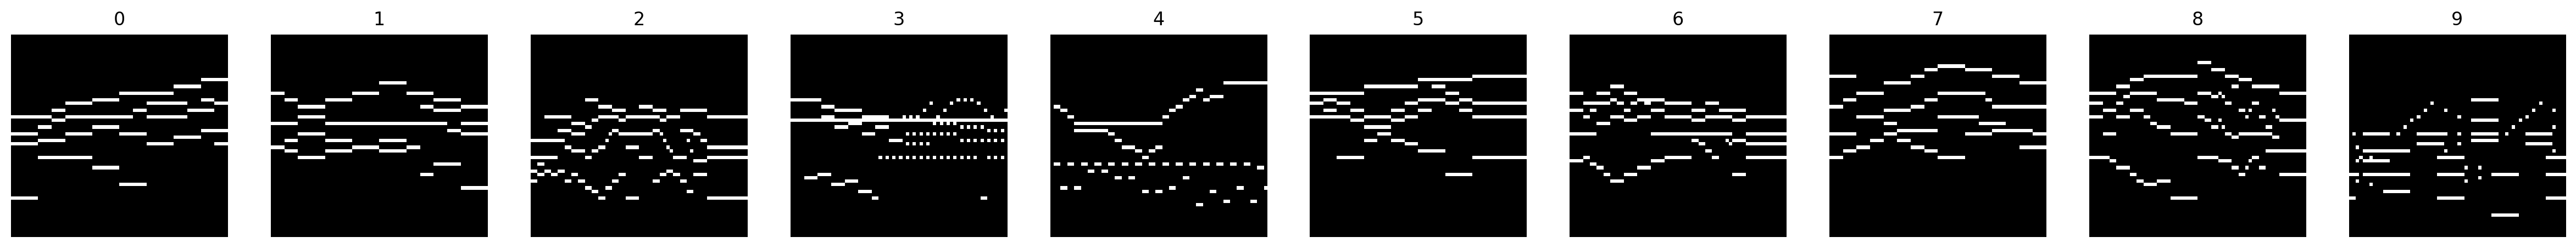

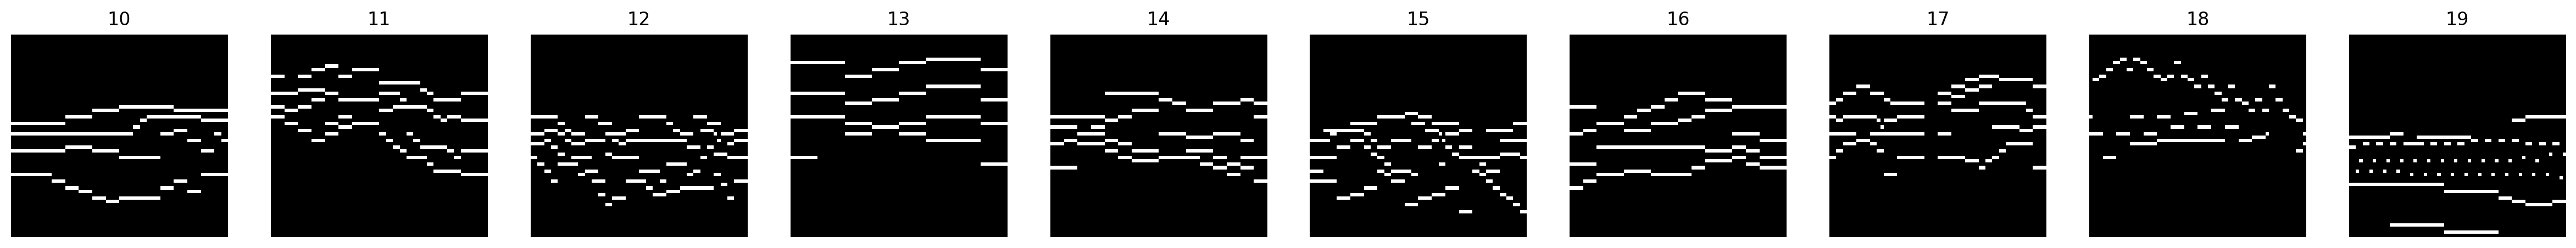

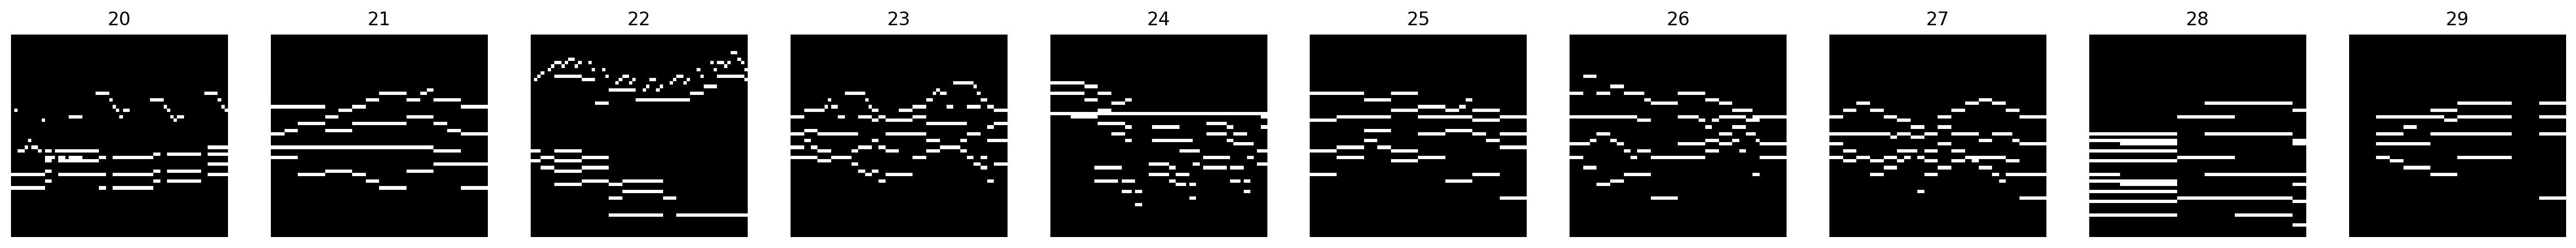

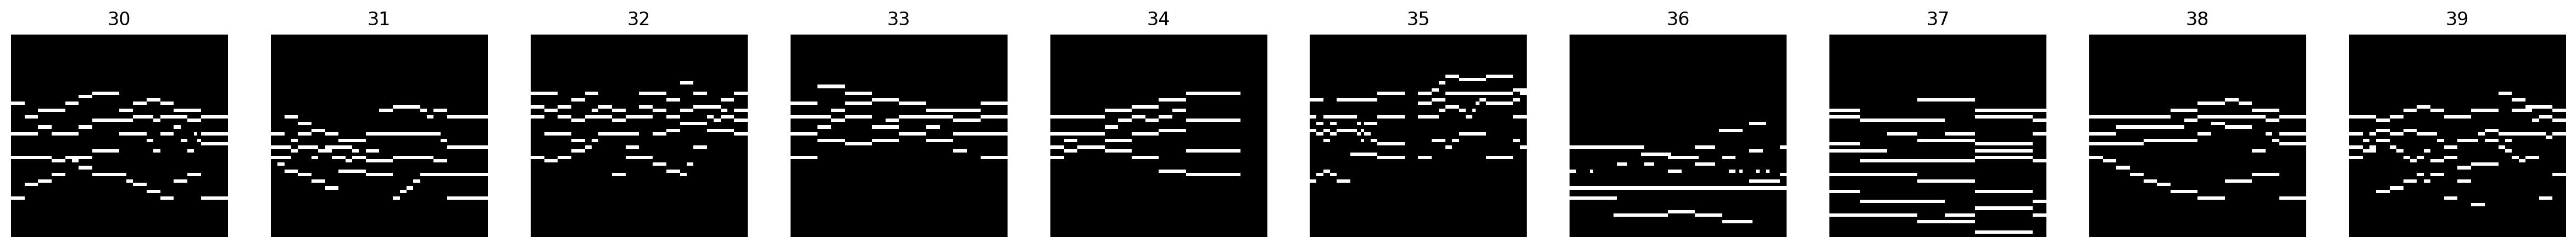

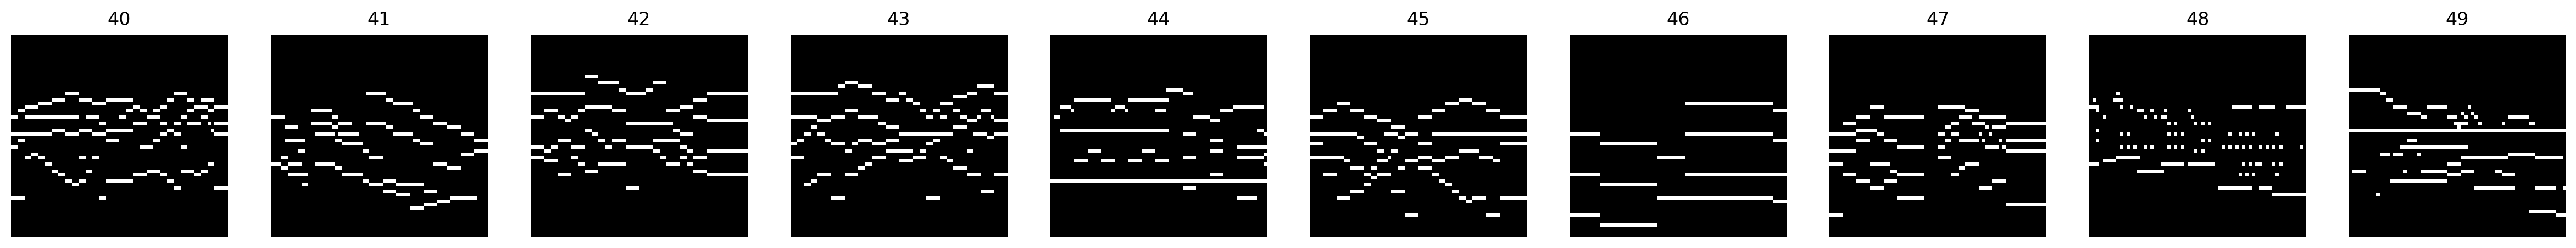

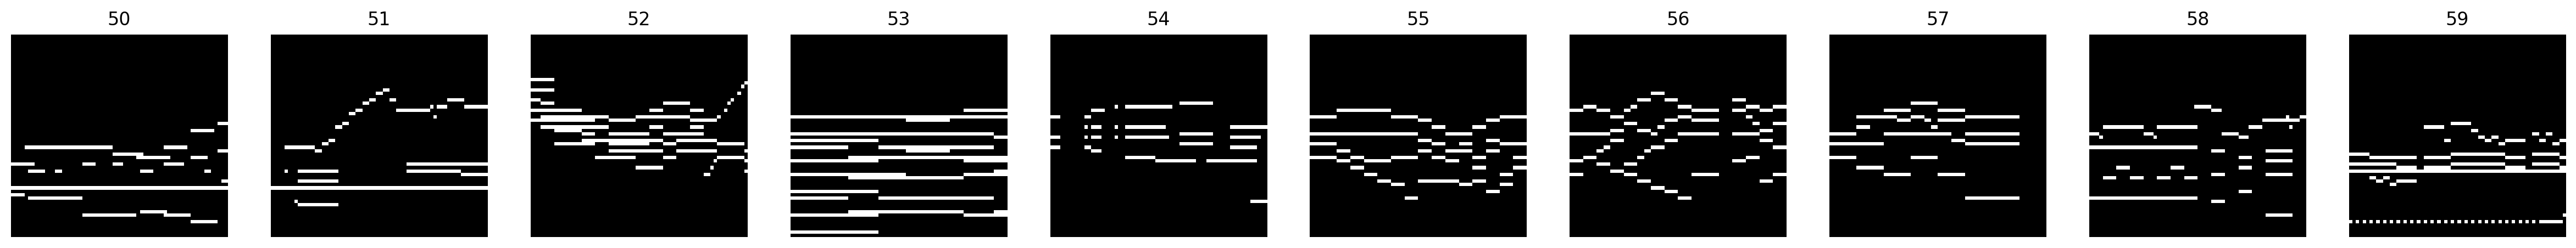

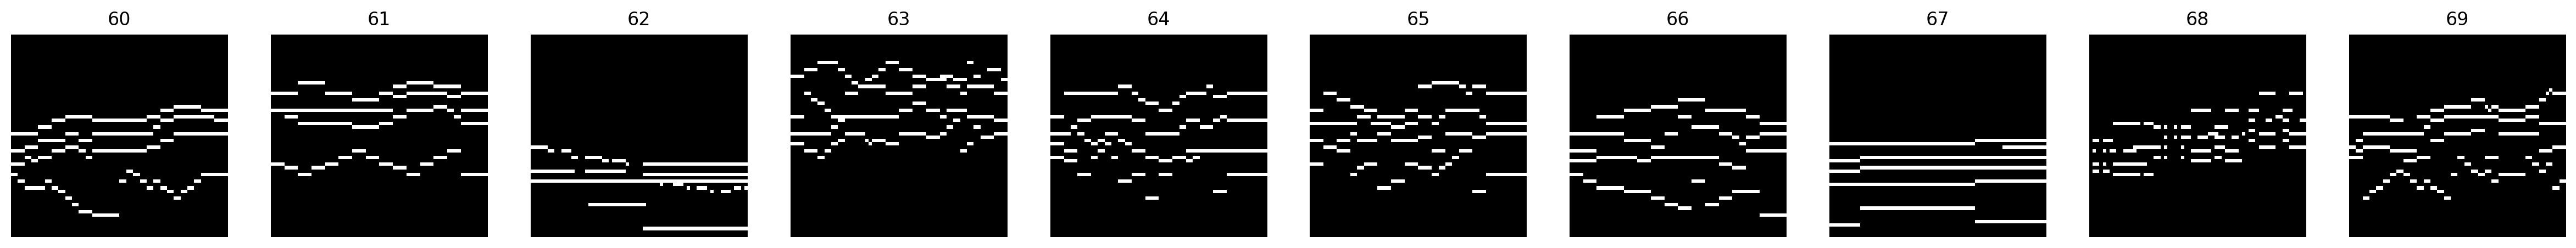

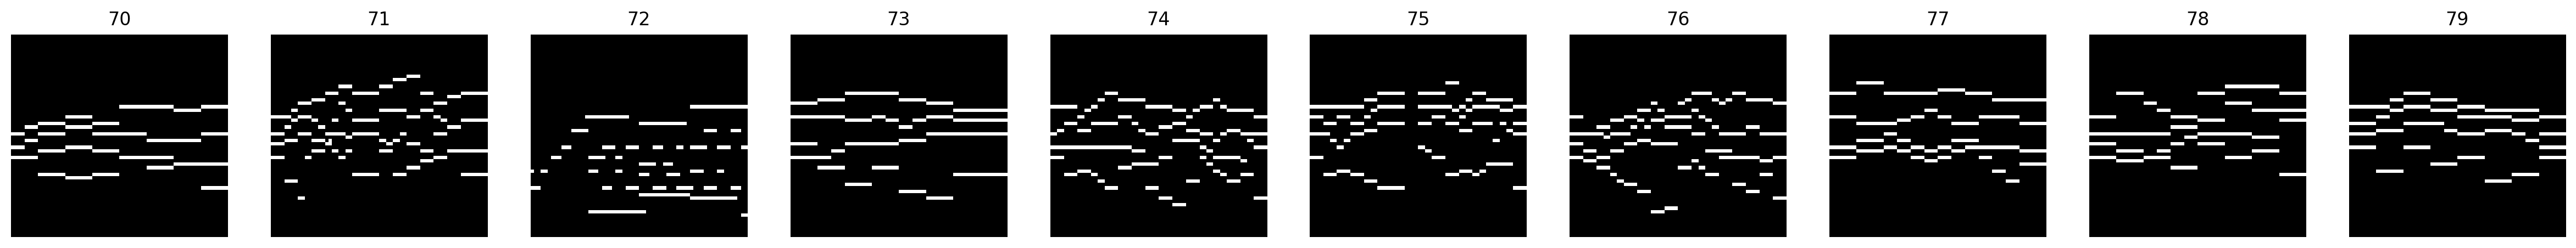

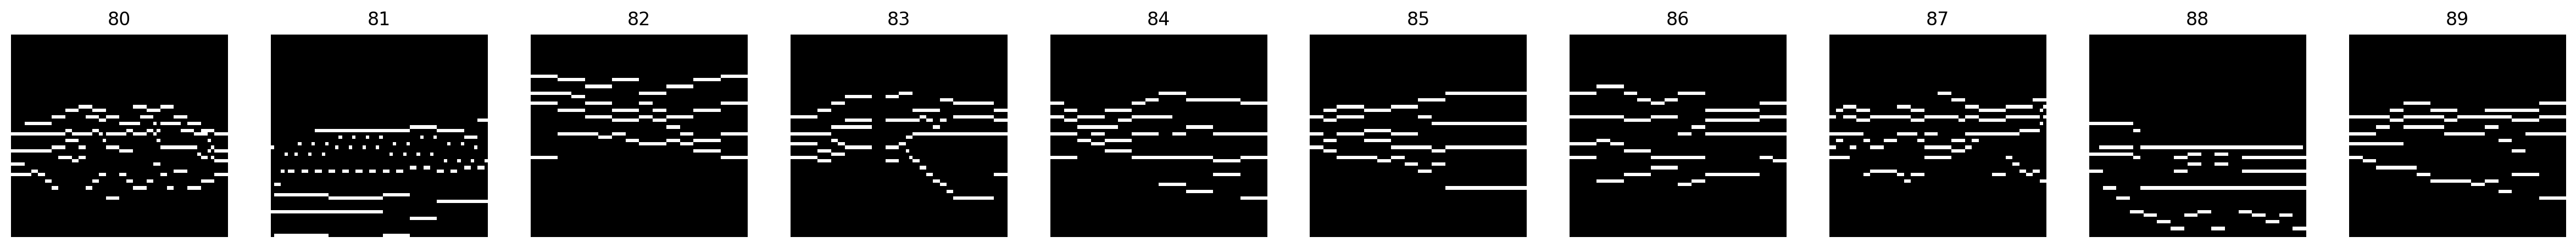

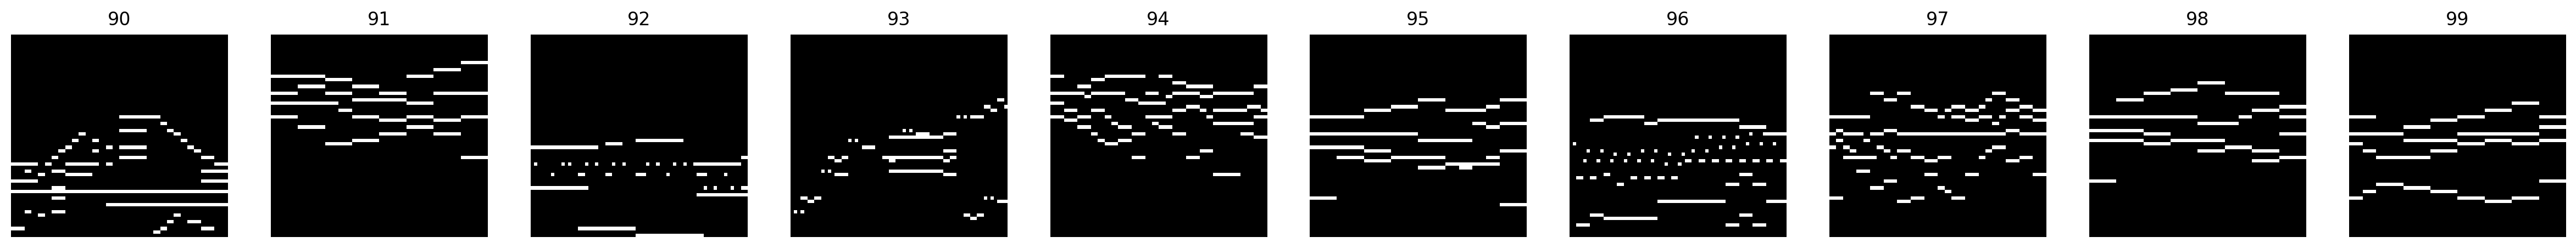

(325, 64, 60, 1)

In [13]:
def jg_plot_rep_dane_wej(piano_representations, start):
    fig = plt.figure(figsize=(30,10))

    axs = fig.subplots(1, 10)

    for i in range(10):
        axs[i].axis('off')
        # plot raw pixel data
        # plt.imshow(piano_representations[i], cmap='gray')
        new_my_pianoroll_rep1 =  np.rot90 (piano_representations[i+ start])
        axs[i].imshow(new_my_pianoroll_rep1, cmap='gray')
        axs[i].set_title(str(i+ start))
    plt.show()

for i in range (10) :
    jg_plot_rep_dane_wej(train_X, 10 * i)
train_X.shape

### Trực quan hóa 1 đầu vào

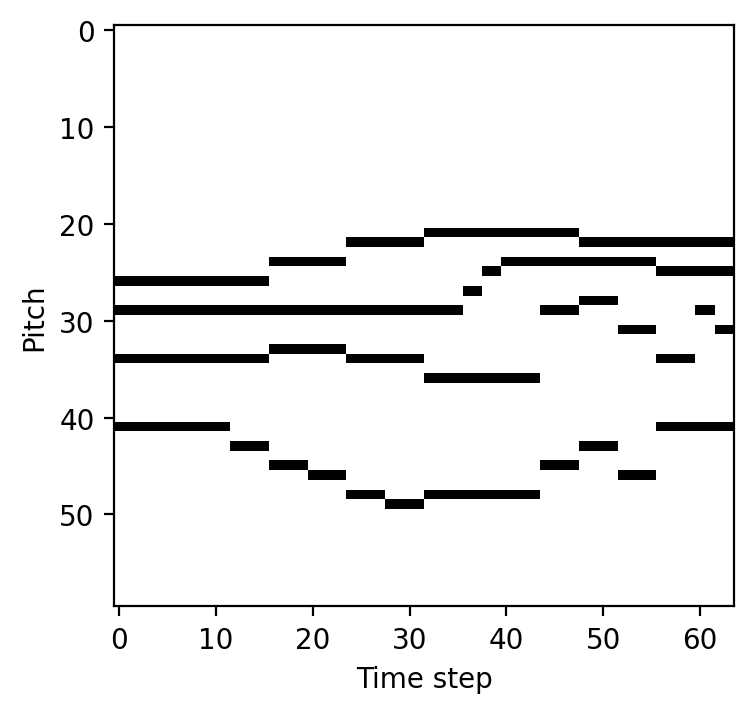

In [14]:
import matplotlib.pyplot as plt
def jg_plot_1_rep_dane_wej(piano_represent_in):
    fig = plt.figure(figsize=(4,4))

    axs = fig.subplots(1, 1)

    new_my_pianoroll_rep1 =  np.rot90 (piano_represent_in)
    new_my_pianoroll_rep1 = 1 - new_my_pianoroll_rep1
    axs.imshow(new_my_pianoroll_rep1, cmap='gray')
    axs.set_xlabel('Time step')
    axs.set_ylabel('Pitch')
    plt.show()

jg_plot_1_rep_dane_wej(train_X[10])   # sad
# jg_plot_1_rep_dane_wej(train_X[3])   # happy
# jg_plot_1_rep_dane_wej(train_X[4])   # happy

## VAE training

In [15]:
@tf.keras.utils.register_keras_serializable()
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super(Sampling, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config()
        return config

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
def encoder(latent_dim=MODEL_CONFIG['latent_dim'], num_emotions=MODEL_CONFIG['num_labels']):
    kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02)

    input_shape = (MODEL_CONFIG['num_timestep'], MODEL_CONFIG['num_pitch'],1)

    music_input = Input(shape=(MODEL_CONFIG['num_timestep'], MODEL_CONFIG['num_pitch']), name="music_input")
    emotion_input = Input(shape=(num_emotions,), name="emotion_input")

    emotion_dense = layers.Dense(input_shape[0] * input_shape[1])(emotion_input)
    emotion_expanded = layers.Reshape(input_shape)(emotion_dense)

    music_input = layers.LSTM(128, return_sequences=False)(music_input)
    music_input = layers.Dense(input_shape[0] * input_shape[1])(music_input)
    music_input = layers.Reshape(input_shape)(music_input)

    combined_input = layers.Concatenate()([music_input, emotion_expanded])

    x = combined_input
    layer1_units = 64
    layer2_units = 128

    p1 = layers.Conv2D(layer1_units, kernel_size=(1, 12), strides=(1, 12))(x)
    p1 = layers.LeakyReLU()(p1)
    p1 = layers.Conv2D(layer2_units, kernel_size=(4, 1), strides=(4, 1))(p1)
    p1 = layers.LeakyReLU()(p1)

    p2 = layers.Conv2D(layer1_units, kernel_size=(4, 1), strides=(4, 1))(x)
    p2 = layers.LeakyReLU()(p2)
    p2 = layers.Conv2D(layer2_units, kernel_size=(1, 12), strides=(1, 12))(p2)
    p2 = layers.LeakyReLU()(p2)

    x = layers.Concatenate(axis=3)([p1, p2])

    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])

    return Model([music_input, emotion_input], [z_mean, z_log_var, z], name="encoder")

# Decoder
def decoder(latent_dim=MODEL_CONFIG['latent_dim'], input_shape=(64, 60, 1), num_emotions=MODEL_CONFIG['num_labels']):
    latent_input = Input(shape=(latent_dim,), name="latent_input")
    emotion_input = Input(shape=(num_emotions,), name="emotion_input")

    x = layers.Concatenate()([latent_input, emotion_input])

    x = layers.Dense(16 * 5 * 128)(x)
    x = layers.Reshape((80, 128))(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.ReLU()(x)

    x = layers.LSTM(128, return_sequences=True)(x)

    x = layers.Reshape((16, 5, 128))(x)
    layer1_units = 64
    layer2_units = 128

    p1 = layers.Conv2DTranspose(layer2_units, kernel_size=(1, 12), strides=(1, 12))(x)
    p1 = layers.BatchNormalization()(p1)
    p1 = layers.ReLU()(p1)
    p1 = layers.Conv2DTranspose(layer1_units, kernel_size=(4, 1), strides=(4, 1))(p1)
    p1 = layers.BatchNormalization()(p1)
    p1 = layers.ReLU()(p1)

    p2 = layers.Conv2DTranspose(layer2_units, kernel_size=(4, 1), strides=(4, 1))(x)
    p2 = layers.BatchNormalization()(p2)
    p2 = layers.ReLU()(p2)
    p2 = layers.Conv2DTranspose(layer1_units, kernel_size=(1, 12), strides=(1, 12))(p2)
    p2 = layers.BatchNormalization()(p2)
    p2 = layers.ReLU()(p2)

    x = layers.Concatenate(axis=3)([p1, p2])

    decoder_outputs = layers.Conv2DTranspose(1, kernel_size=(1, 1), strides=(1, 1), activation="sigmoid", padding="same")(x)

    return Model([latent_input, emotion_input], decoder_outputs, name="decoder")

In [16]:
# Plot and Generate Labels Functions
def jg_plot_rep(piano_representations, epoch, config, name):
    fig = plt.figure(figsize=(30, 20))
    num_samples = piano_representations.shape[0]
    axs = fig.subplots(1, num_samples)
    for i in range(num_samples):
        axs[i].axis('off')
        new_my_pianoroll_rep1 = np.rot90(piano_representations[i])
        axs[i].imshow(new_my_pianoroll_rep1, cmap='gray')
        axs[i].set_title(str(i))
    filename1 = f'Samples_{num_samples}_images_{epoch + 1}_{name}.png'
    plt.savefig(filename1)
    plt.close()

def jg_generate_labels(num_sample):
    cond_num = np.zeros((num_sample, 1))
    for i in range(num_sample):
        ind = (i % 4)
        cond_num[i] = ind
    condition_emo = to_categorical(cond_num, 4)
    return condition_emo

def jg_back_to_pianoroll(samples):
    print("samples: ", samples.shape)

    samples_piano_representations_arr = np.reshape (samples, (samples.shape[0], samples.shape[1], samples.shape[2] ) )
    samples_p_rep = samples_piano_representations_arr
    samples_pianoroll_rep =  np.pad(samples_p_rep, ( (0, 0), (0, 0), (25, 43)) , 'constant', constant_values=( 0, 0))
    print("samples_pianoroll_rep.shape: ", samples_pianoroll_rep.shape)
    return samples_pianoroll_rep

def jg_save_midi_samples(samples_pianoroll, epoch, config):
    for i in range(samples_pianoroll.shape[0]):
        my_music = muspy.from_pianoroll_representation (samples_pianoroll[i], resolution=4, encode_velocity=False)

        filename1 = 'MIDI_epoch_%04d_%s.mid' % (epoch+1, i)
        path = os.path.join(config['result_dir'], filename1)
        muspy.write_midi(path , my_music)
        print('MIDI saved to %s' % path)

In [17]:
# CVAE Class
class CVAE(Model):
    def __init__(self, encoder, decoder, initial_beta_kl=0.1, final_beta_kl=1.0):
        super(CVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta_kl = initial_beta_kl
        self.final_beta_kl = final_beta_kl

    def train_step(self, data):
        music_input, emotion_input = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([music_input, emotion_input])
            reconstruction = self.decoder([z, emotion_input])

            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(music_input, reconstruction), axis=(1, 2)
                    # tf.keras.losses.mean_squared_error(music_input, reconstruction)
                )
            )
            # KL Divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + self.beta_kl * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

    def call(self, inputs):
        music_input, emotion_input = inputs
        z_mean, z_log_var, z = self.encoder([music_input, emotion_input])
        reconstruction = self.decoder([z, emotion_input])
        return reconstruction

    def run_sampler(self, epoch, config):
        num_sample = config['num_sample']
        latent_dim = config['latent_dim']
        z_sample = tf.random.normal(shape=(num_sample, latent_dim))
        print("z_sample.shape: ", z_sample.shape)

        condition_emo = jg_generate_labels(num_sample)
        print("condition_emo[0]: ", condition_emo[0])
        x_decoded = self.decoder.predict([z_sample, condition_emo])
        x_decoded_round = x_decoded > 0.5

        print("x_decoded.shape: ", x_decoded.shape)

        jg_plot_rep(x_decoded_round, epoch, config, name='vae_rounded')
        return x_decoded_round

In [18]:
# Compile and Train CVAE
latent_dim = MODEL_CONFIG['latent_dim']
encoder_model = encoder(latent_dim=latent_dim)
decoder_model = decoder(latent_dim=latent_dim)

# Define the initial learning rate
initial_learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

cvae = CVAE(encoder_model, decoder_model, initial_beta_kl=0.1, final_beta_kl=1.0)
cvae.compile(optimizer)

# Summarize the architecture
cvae.encoder.summary()
cvae.decoder.summary()

loss_all, reconstruction_loss_all, kl_loss_all = [], [], []

num_epochs = TRAIN_CONFIG['num_epoch']
batch_size = MODEL_CONFIG['batch_size']

# train_y_onehot = labels_to_categorical(train_y)

print("Final shapes before training:")
print("train_X shape:", train_X.shape)
print("train_y_onehot shape:", train_y_onehot.shape)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ emotion_input             │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 3840)           │         19,200 │ emotion_input[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ keras_tensor_4CLONE       │ (None, 64, 60, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 64, 60, 1)      │              0 │ dense[1][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 60, 2)      │              0 │ keras_tensor_4CLONE[1… │
│                           │                        │                │ reshape[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 5, 64)      │          1,600 │ concatenate[1][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 60, 64)     │            576 │ concatenate[1][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 64, 5, 64)      │              0 │ conv2d[1][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 16, 60, 64)     │              0 │ conv2d_2[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 5, 128)     │         32,896 │ leaky_re_lu[1][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 5, 128)     │         98,432 │ leaky_re_lu_2[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 16, 5, 128)     │              0 │ conv2d_1[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 16, 5, 128)     │              0 │ conv2d_3[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 16, 5, 256)     │              0 │ leaky_re_lu_1[1][0],   │
│ (Concatenate)             │                        │                │ leaky_re_lu_3[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 20480)          │              0 │ concatenate_1[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │      1,310,784 │ flatten[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense_2[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)       

 Total params: 1,467,648 (5.60 MB)

 Trainable params: 1,467,648 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ latent_input (InputLayer) │ (None, 32)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emotion_input             │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 36)             │              0 │ latent_input[0][0],    │
│ (Concatenate)             │                        │                │ emotion_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 10240)          │        378,880 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 80, 128)        │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 80, 128)        │        131,584 │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 16, 5, 128)     │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 60, 128)    │        196,736 │ reshape_3[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 64, 5, 128)     │         65,664 │ reshape_3[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16, 60, 128)    │            512 │ conv2d_transpose[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 5, 128)     │            512 │ conv2d_transpose_2[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 16, 60, 128)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 64, 5, 128)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 64, 60, 64)     │         32,832 │ re_lu[0][0]            │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 64, 60, 64)     │         98,368 │ re_lu_2[0][0]          │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1

 Total params: 905,729 (3.46 MB)

 Trainable params: 904,961 (3.45 MB)

 Non-trainable params: 768 (3.00 KB)

Final shapes before training:
train_X shape: (325, 64, 60, 1)
train_y_onehot shape: (325, 4)


In [19]:
# Training Loop with KL Annealing
config = {
    'num_sample': 10,
    'latent_dim': latent_dim
    }
# batch_size = MODEL_CONFIG['batch_size']
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Update beta_kl for KL Annealing
    cvae.beta_kl += (cvae.final_beta_kl - cvae.beta_kl) / num_epochs

    history = cvae.fit(x=[train_X, train_y_onehot],
                      epochs=1,
                      batch_size=MODEL_CONFIG['batch_size'])

    # Log the losses
    loss_all.append(history.history['loss'][0])
    reconstruction_loss_all.append(history.history['reconstruction_loss'][0])
    kl_loss_all.append(history.history['kl_loss'][0])

    # Save checkpoints and run sampler as needed
    if (epoch + 1) % 10 == 0:
        cvae.save(f'./checkpoints/cvae_epoch_{epoch + 1}.h5')

    if TRAIN_CONFIG['evaluate_along_training'] and (epoch + 1) % 100 == 0:
        cvae.run_sampler(epoch + 1, MODEL_CONFIG)

    if (epoch + 1) % 10 == 0:
        samples = cvae.run_sampler(epoch, MODEL_CONFIG)
        samples_pianoroll =  jg_back_to_pianoroll(samples)
        jg_save_midi_samples(samples_pianoroll, epoch, MODEL_CONFIG)
        # for i, sample in enumerate(samples):
        #     piano_roll_to_midi(sample[:, :, 0], filename=f'./midi/sample_epoch_{epoch + 1}_sample_{i}.mid')

# Finalize training
print("Training complete!")
cvae.save(f'./checkpoints/cvae_final_epoch_{num_epochs}.h5')

Epoch 1/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - kl_loss: 103.9365 - loss: 1188.7117 - reconstruction_loss: 1178.0842
Epoch 2/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - kl_loss: 54.3988 - loss: 767.5424 - reconstruction_loss: 761.9800
Epoch 3/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - kl_loss: 34.4304 - loss: 746.7277 - reconstruction_loss: 743.2072
Epoch 4/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - kl_loss: 46.6372 - loss: 709.7629 - reconstruction_loss: 704.9943
Epoch 5/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - kl_loss: 58.4076 - loss: 677.7992 - reconstruction_loss: 671.8270
Epoch 6/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - kl_loss: 58.4195 - loss: 662.0454 - reconstruction_loss: 656.0720
Epoch 7/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - kl_loss: 58.2782 - loss: 648.6973 - reconstruction_loss: 642.7384
Epoch 8/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 56.4050 - loss: 646.9070 - reconstruction_loss: 641.1396
Epoch 9/400
41/41 ━━━━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0010_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0010_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0010_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0010_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0010_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0010_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0010_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0010_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0010_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0010_9.mid
Epoch 11/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - kl_loss: 59.7892 - loss: 622.6541 - reconstruction_loss: 616.5406
Epoch 12/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - kl_loss: 66.5972 - loss: 620.4449 - reconstruction_loss: 613.6353
Epoch 13/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0020_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0020_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0020_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0020_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0020_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0020_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0020_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0020_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0020_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0020_9.mid
Epoch 21/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - kl_loss: 107.3735 - loss: 502.7975 - reconstruction_loss: 491.8185
Epoch 22/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 114.7757 - loss: 486.0921 - reconstruction_loss: 474.3563
Epoch 23/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0030_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0030_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0030_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0030_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0030_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0030_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0030_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0030_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0030_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0030_9.mid
Epoch 31/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - kl_loss: 158.0894 - loss: 341.8480 - reconstruction_loss: 325.6833
Epoch 32/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 165.9845 - loss: 329.0985 - reconstruction_loss: 312.1266
Epoch 33/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0040_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0040_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0040_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0040_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0040_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0040_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0040_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0040_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0040_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0040_9.mid
Epoch 41/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - kl_loss: 196.5665 - loss: 237.3498 - reconstruction_loss: 217.2509
Epoch 42/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 191.5363 - loss: 223.2516 - reconstruction_loss: 203.6670
Epoch 43/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0050_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0050_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0050_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0050_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0050_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0050_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0050_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0050_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0050_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0050_9.mid
Epoch 51/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 172.0351 - loss: 129.7673 - reconstruction_loss: 112.1767
Epoch 52/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 175.8787 - loss: 129.5908 - reconstruction_loss: 111.6072
Epoch 53/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0060_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0060_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0060_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0060_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0060_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0060_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0060_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0060_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0060_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0060_9.mid
Epoch 61/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - kl_loss: 167.5403 - loss: 79.3410 - reconstruction_loss: 62.2100
Epoch 62/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 164.6154 - loss: 72.6078 - reconstruction_loss: 55.7759
Epoch 63/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0070_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0070_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0070_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0070_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0070_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0070_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0070_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0070_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0070_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0070_9.mid
Epoch 71/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - kl_loss: 156.6639 - loss: 59.6919 - reconstruction_loss: 43.6730
Epoch 72/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 154.1423 - loss: 55.9835 - reconstruction_loss: 40.2224
Epoch 73/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0080_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0080_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0080_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0080_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0080_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0080_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0080_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0080_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0080_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0080_9.mid
Epoch 81/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 108.5764 - loss: 16.6275 - reconstruction_loss: 5.5256
Epoch 82/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - kl_loss: 105.6342 - loss: 15.7883 - reconstruction_loss: 4.9872
Epoch 83/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/ste

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0090_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0090_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0090_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0090_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0090_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0090_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0090_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0090_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0090_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0090_9.mid
Epoch 91/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 93.5148 - loss: 13.0872 - reconstruction_loss: 3.5253
Epoch 92/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 93.7106 - loss: 12.6811 - reconstruction_loss: 3.0991
Epoch 93/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step 

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0100_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0100_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0100_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0100_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0100_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0100_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0100_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0100_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0100_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0100_9.mid
Epoch 101/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - kl_loss: 126.6611 - loss: 51.4210 - reconstruction_loss: 38.4699
Epoch 102/400
41/41 ━━━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0110_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0110_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0110_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0110_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0110_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0110_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0110_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0110_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0110_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0110_9.mid
Epoch 111/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - kl_loss: 85.0442 - loss: 10.7003 - reconstruction_loss: 2.0046
Epoch 112/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - kl_loss: 83.0599 - loss: 11.1977 - reconstruction_loss: 2.7048
Epoch 113/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/st

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0120_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0120_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0120_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0120_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0120_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0120_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0120_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0120_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0120_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0120_9.mid
Epoch 121/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - kl_loss: 101.0325 - loss: 19.8399 - reconstruction_loss: 9.5093
Epoch 122/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - kl_loss: 104.3196 - loss: 20.8828 - reconstruction_loss: 10.2161
Epoch 123/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0130_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0130_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0130_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0130_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0130_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0130_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0130_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0130_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0130_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0130_9.mid
Epoch 131/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - kl_loss: 100.9349 - loss: 18.6549 - reconstruction_loss: 8.3343
Epoch 132/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - kl_loss: 103.6150 - loss: 22.0147 - reconstruction_loss: 11.4201
Epoch 133/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0140_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0140_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0140_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0140_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0140_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0140_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0140_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0140_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0140_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0140_9.mid
Epoch 141/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - kl_loss: 86.8002 - loss: 11.2370 - reconstruction_loss: 2.3617
Epoch 142/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - kl_loss: 83.1725 - loss: 10.4044 - reconstruction_loss: 1.9001
Epoch 143/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/st

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0150_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0150_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0150_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0150_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0150_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0150_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0150_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0150_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0150_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0150_9.mid
Epoch 151/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 86.3831 - loss: 12.4339 - reconstruction_loss: 3.6013
Epoch 152/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - kl_loss: 88.3462 - loss: 12.2868 - reconstruction_loss: 3.2534
Epoch 153/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/st

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0160_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0160_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0160_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0160_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0160_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0160_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0160_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0160_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0160_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0160_9.mid
Epoch 161/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 96.7585 - loss: 21.5184 - reconstruction_loss: 11.6248
Epoch 162/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 95.2571 - loss: 18.0920 - reconstruction_loss: 8.3519
Epoch 163/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0170_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0170_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0170_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0170_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0170_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0170_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0170_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0170_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0170_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0170_9.mid
Epoch 171/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 76.1973 - loss: 9.1191 - reconstruction_loss: 1.3279
Epoch 172/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - kl_loss: 74.5393 - loss: 8.8884 - reconstruction_loss: 1.2667
Epoch 173/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0180_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0180_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0180_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0180_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0180_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0180_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0180_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0180_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0180_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0180_9.mid
Epoch 181/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 77.1032 - loss: 11.5394 - reconstruction_loss: 3.6556
Epoch 182/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 80.8622 - loss: 13.8250 - reconstruction_loss: 5.5568
Epoch 183/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/st

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0190_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0190_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0190_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0190_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0190_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0190_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0190_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0190_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0190_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0190_9.mid
Epoch 191/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 83.7997 - loss: 13.0712 - reconstruction_loss: 4.5027
Epoch 192/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 82.1715 - loss: 12.0765 - reconstruction_loss: 3.6744
Epoch 193/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/st

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0200_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0200_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0200_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0200_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0200_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0200_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0200_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0200_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0200_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0200_9.mid
Epoch 201/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - kl_loss: 98.7445 - loss: 32.4287 - reconstruction_loss: 22.3321
Epoch 202/400
41/41 ━━━━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0210_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0210_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0210_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0210_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0210_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0210_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0210_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0210_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0210_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0210_9.mid
Epoch 211/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 70.6886 - loss: 8.3873 - reconstruction_loss: 1.1594
Epoch 212/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 71.1727 - loss: 8.7015 - reconstruction_loss: 1.4241
Epoch 213/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0220_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0220_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0220_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0220_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0220_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0220_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0220_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0220_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0220_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0220_9.mid
Epoch 221/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 93.5966 - loss: 16.9795 - reconstruction_loss: 7.4092
Epoch 222/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 84.0286 - loss: 11.4955 - reconstruction_loss: 2.9035
Epoch 223/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/st

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0230_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0230_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0230_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0230_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0230_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0230_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0230_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0230_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0230_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0230_9.mid
Epoch 231/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 74.0368 - loss: 8.8429 - reconstruction_loss: 1.2726
Epoch 232/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 73.2636 - loss: 9.1682 - reconstruction_loss: 1.6770
Epoch 233/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0240_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0240_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0240_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0240_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0240_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0240_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0240_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0240_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0240_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0240_9.mid
Epoch 241/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - kl_loss: 70.6738 - loss: 8.7032 - reconstruction_loss: 1.4768
Epoch 242/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 70.7567 - loss: 9.2525 - reconstruction_loss: 2.0177
Epoch 243/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0250_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0250_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0250_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0250_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0250_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0250_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0250_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0250_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0250_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0250_9.mid
Epoch 251/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - kl_loss: 82.3423 - loss: 15.7700 - reconstruction_loss: 7.3505
Epoch 252/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 83.7581 - loss: 18.8478 - reconstruction_loss: 10.2835
Epoch 253/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0260_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0260_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0260_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0260_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0260_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0260_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0260_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0260_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0260_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0260_9.mid
Epoch 261/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - kl_loss: 69.8456 - loss: 8.4824 - reconstruction_loss: 1.3407
Epoch 262/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 68.7289 - loss: 8.5436 - reconstruction_loss: 1.5161
Epoch 263/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0270_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0270_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0270_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0270_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0270_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0270_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0270_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0270_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0270_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0270_9.mid
Epoch 271/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - kl_loss: 81.9885 - loss: 14.7460 - reconstruction_loss: 6.3627
Epoch 272/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 79.4571 - loss: 13.1958 - reconstruction_loss: 5.0713
Epoch 273/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/st

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0280_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0280_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0280_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0280_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0280_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0280_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0280_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0280_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0280_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0280_9.mid
Epoch 281/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - kl_loss: 71.8238 - loss: 8.4682 - reconstruction_loss: 1.1242
Epoch 282/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 72.7308 - loss: 8.7299 - reconstruction_loss: 1.2932
Epoch 283/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0290_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0290_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0290_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0290_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0290_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0290_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0290_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0290_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0290_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0290_9.mid
Epoch 291/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - kl_loss: 74.1803 - loss: 10.8963 - reconstruction_loss: 3.3114
Epoch 292/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - kl_loss: 75.2994 - loss: 9.7584 - reconstruction_loss: 2.0590
Epoch 293/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/ste

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0300_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0300_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0300_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0300_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0300_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0300_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0300_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0300_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0300_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0300_9.mid
Epoch 301/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - kl_loss: 79.8193 - loss: 13.4287 - reconstruction_loss: 5.2672
Epoch 302/400
41/41 ━━━━━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0310_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0310_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0310_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0310_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0310_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0310_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0310_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0310_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0310_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0310_9.mid
Epoch 311/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - kl_loss: 71.6038 - loss: 9.6248 - reconstruction_loss: 2.3033
Epoch 312/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 73.1738 - loss: 10.5127 - reconstruction_loss: 3.0307
Epoch 313/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/ste

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0320_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0320_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0320_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0320_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0320_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0320_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0320_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0320_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0320_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0320_9.mid
Epoch 321/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - kl_loss: 76.7646 - loss: 11.3897 - reconstruction_loss: 3.5405
Epoch 322/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - kl_loss: 75.0622 - loss: 10.7228 - reconstruction_loss: 3.0477
Epoch 323/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/st

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0330_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0330_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0330_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0330_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0330_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0330_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0330_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0330_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0330_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0330_9.mid
Epoch 331/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 76.6741 - loss: 11.3378 - reconstruction_loss: 3.4979
Epoch 332/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - kl_loss: 74.9999 - loss: 10.7643 - reconstruction_loss: 3.0955
Epoch 333/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/st

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0340_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0340_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0340_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0340_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0340_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0340_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0340_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0340_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0340_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0340_9.mid
Epoch 341/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 71.8872 - loss: 10.4684 - reconstruction_loss: 3.1179
Epoch 342/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 75.2710 - loss: 11.4160 - reconstruction_loss: 3.7195
Epoch 343/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/st

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0350_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0350_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0350_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0350_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0350_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0350_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0350_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0350_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0350_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0350_9.mid
Epoch 351/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 70.8640 - loss: 8.9225 - reconstruction_loss: 1.6766
Epoch 352/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - kl_loss: 73.0392 - loss: 10.0795 - reconstruction_loss: 2.6112
Epoch 353/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/ste

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0360_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0360_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0360_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0360_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0360_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0360_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0360_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0360_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0360_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0360_9.mid
Epoch 361/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 91.3389 - loss: 14.3241 - reconstruction_loss: 4.9847
Epoch 362/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 80.7984 - loss: 11.4889 - reconstruction_loss: 3.2273
Epoch 363/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/st

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0370_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0370_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0370_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0370_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0370_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0370_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0370_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0370_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0370_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0370_9.mid
Epoch 371/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 65.8843 - loss: 8.3951 - reconstruction_loss: 1.6584
Epoch 372/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 69.0811 - loss: 10.1943 - reconstruction_loss: 3.1307
Epoch 373/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/ste

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0380_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0380_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0380_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0380_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0380_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0380_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0380_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0380_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0380_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0380_9.mid
Epoch 381/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 64.2857 - loss: 7.5705 - reconstruction_loss: 0.9973
Epoch 382/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 64.3827 - loss: 7.6773 - reconstruction_loss: 1.0942
Epoch 383/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0390_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0390_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0390_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0390_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0390_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0390_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0390_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0390_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0390_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0390_9.mid
Epoch 391/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 71.7350 - loss: 10.8725 - reconstruction_loss: 3.5376
Epoch 392/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 72.3000 - loss: 10.7956 - reconstruction_loss: 3.4029
Epoch 393/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/st

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)


samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0400_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0400_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0400_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0400_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0400_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0400_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0400_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0400_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0400_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0400_9.mid
Training complete!


In [20]:
!zip -r /content/gen3.zip /content/gen

  adding: content/gen/ (stored 0%)
  adding: content/gen/MIDI_epoch_0100_8.mid (deflated 45%)
  adding: content/gen/MIDI_epoch_0260_5.mid (deflated 44%)
  adding: content/gen/MIDI_epoch_0150_8.mid (deflated 37%)
  adding: content/gen/MIDI_epoch_0380_3.mid (deflated 33%)
  adding: content/gen/MIDI_epoch_0070_7.mid (deflated 10%)
  adding: content/gen/MIDI_epoch_0160_1.mid (deflated 48%)
  adding: content/gen/MIDI_epoch_0120_6.mid (deflated 41%)
  adding: content/gen/MIDI_epoch_0100_6.mid (deflated 44%)
  adding: content/gen/MIDI_epoch_0080_5.mid (deflated 49%)
  adding: content/gen/MIDI_epoch_0350_3.mid (deflated 42%)
  adding: content/gen/MIDI_epoch_0190_5.mid (deflated 46%)
  adding: content/gen/MIDI_epoch_0380_8.mid (deflated 40%)
  adding: content/gen/MIDI_epoch_0280_9.mid (deflated 39%)
  adding: content/gen/MIDI_epoch_0330_6.mid (deflated 40%)
  adding: content/gen/MIDI_epoch_0360_5.mid (deflated 36%)
  adding: content/gen/MIDI_epoch_0310_5.mid (deflated 45%)
  adding: content/gen

In [ ]:
cvae.load_weights('/content/checkpoints/cvae_epoch_150.h5')

# Using a decoder network to generate images from any implicit vector space:

In [ ]:
latent_dim = MODEL_CONFIG['latent_dim']
z_sample = np.zeros([latent_dim])
z_sample
z_sample [0] = 0.5
z_sample [1] = -0.5
# grid_x = np.linspace(-1, 1, 10)
# grid_x
z_sample.shape
z_sample = np.reshape(z_sample, (1, latent_dim) )
z_sample.shape

(1, 32)

## Test run_sampler

cond_num.shape:  (10, 1)
0 1 2 3 0 1 2 3 0 1 
condition_emo.shape:  (10, 4)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
../content/gen/Samples_10_images_0501_vae_rounded.png


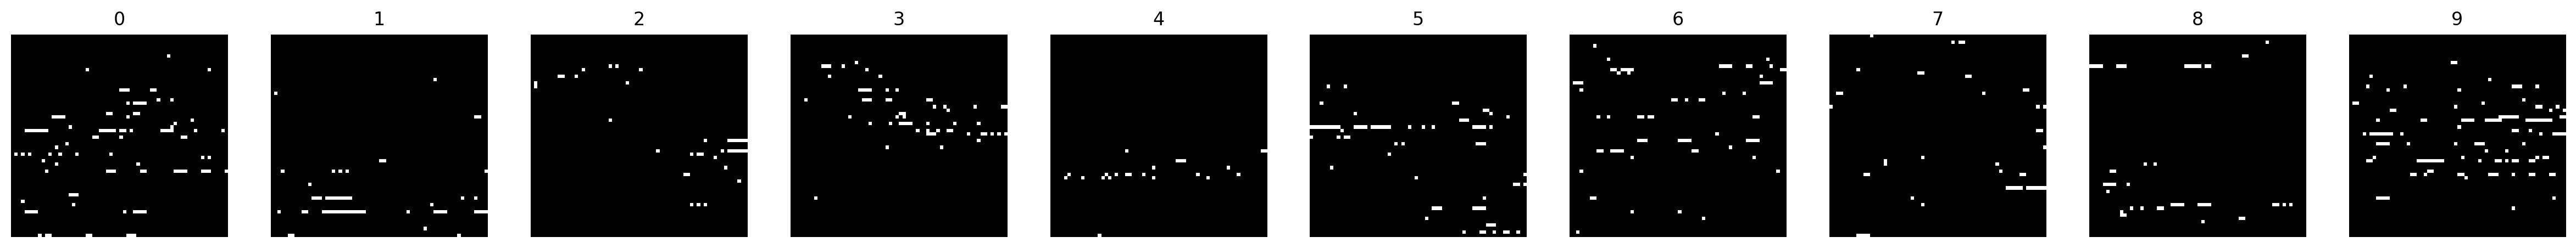

In [ ]:
# Generuje ilość num_sample labels  with values [0-4 ]
def jg_generate_labels(num_sample):
    import numpy as np
    from tensorflow.keras.utils import to_categorical

    cond_num = np.zeros((num_sample, 1))
    print("cond_num.shape: ", cond_num.shape)
    for i in range(num_sample):
        ind = i % 4
        print(ind, end=' ')
        cond_num[i] = ind
    print()
    condition_emo = to_categorical(cond_num, 4)
    print("condition_emo.shape: ", condition_emo.shape)
    return condition_emo

# Plot piano_representations
import os

# ... existing code ...

def jg_plot_rep(piano_representations, epoch, config, name):
    fig = plt.figure(figsize=(30,20))

    num_samples = piano_representations.shape[0]
    axs = fig.subplots(1, num_samples)

    for i in range(num_samples):
        axs[i].axis('off')
        new_my_pianoroll_rep1 =  np.rot90 (piano_representations[i])
#         new_my_pianoroll_rep1 = 1 - new_my_pianoroll_rep1

        axs[i].imshow(new_my_pianoroll_rep1, cmap='gray')
        axs[i].set_title(str(i))

#     epoch = epochs
    filename1 = 'Samples_%s_images_%04d_%s.png' % (num_samples, epoch+1, name)
    path = os.path.join(MODEL_CONFIG['result_dir'], filename1)

    # Create directory if it doesn't exist
    os.makedirs(MODEL_CONFIG['result_dir'], exist_ok=True)

    print (path)
    plt.savefig(path)
    plt.show()

# ... existing code ...

def jg_run_sampler(vae, epoch, config):
    num_sample = MODEL_CONFIG['num_sample']
    latent_dim = MODEL_CONFIG['latent_dim']
    z_sample = tf.random.normal(shape=(num_sample, latent_dim ))
    # print("z_sample.shape: ", z_sample.shape)

    condition_emo = jg_generate_labels(num_sample)
    print("condition_emo[0]: ", condition_emo[0])
    x_decoded = vae.decoder.predict([z_sample, condition_emo])
    x_decoded_round = x_decoded > 0.7

    # print("x_decoded.shape: ", x_decoded.shape)

    jg_plot_rep(x_decoded_round, epoch, config, name = 'vae_rounded')
    return x_decoded_round

# result_dir = './../result_dir/'
samples = jg_run_sampler(cvae, 500, MODEL_CONFIG)

## Test  jg_back_to_pianoroll

In [ ]:
def jg_back_to_pianoroll(samples):
    print("samples: ", samples.shape)

    samples_piano_representations_arr = np.reshape (samples, (samples.shape[0], samples.shape[1], samples.shape[2] ) )
    samples_p_rep = samples_piano_representations_arr
    samples_pianoroll_rep =  np.pad(samples_p_rep, ( (0, 0), (0, 0), (25, 43)) , 'constant', constant_values=( 0, 0))
    print("samples_pianoroll_rep.shape: ", samples_pianoroll_rep.shape)
    return samples_pianoroll_rep

def jg_save_midi_samples(samples_pianoroll, epoch, config):
    for i in range(samples_pianoroll.shape[0]):
        my_music = muspy.from_pianoroll_representation (samples_pianoroll[i], resolution=4, encode_velocity=False)

#         print(my_music)
        filename1 = 'MIDI_epoch_%04d_%s.mid' % (epoch, i )
        path = os.path.join(config['result_dir'], filename1)
        muspy.write_midi(path , my_music)
        print('MIDI saved to %s' % path)

samples_pianoroll =  jg_back_to_pianoroll(samples)

jg_save_midi_samples(samples_pianoroll, 500, MODEL_CONFIG)

samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0500_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_9.mid


## Wizualizacjia latent space z grupami klas cyfr

train_y_onehot.shape:  (241, 4)
train_y_onehot[0]:  [1. 0. 0. 0.]
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


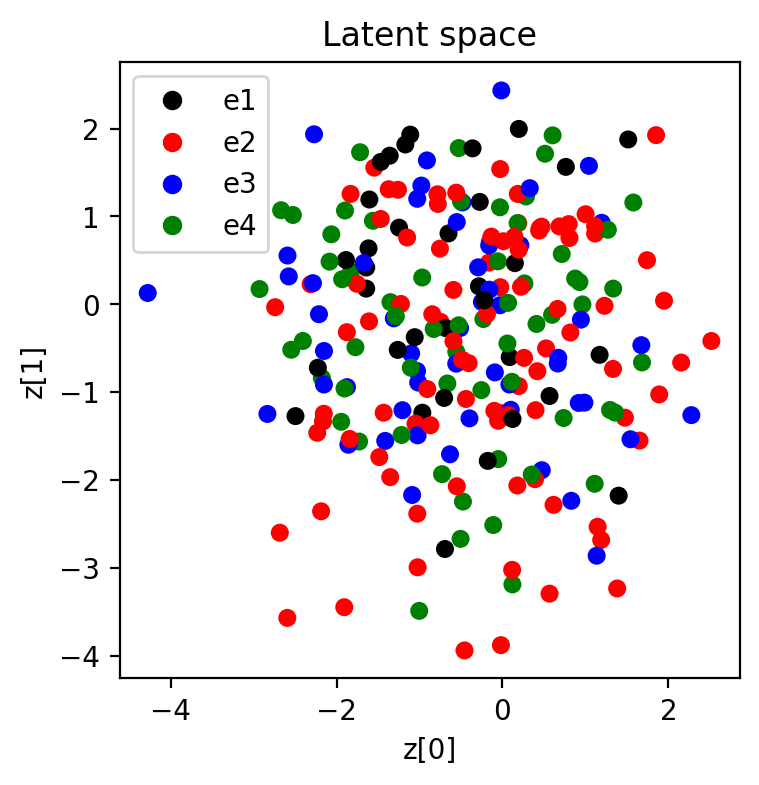

z_mean.shape (241, 32)
0 mean:  -0.42996553 std:  1.2159244
1 mean:  -0.33059946 std:  1.3194864
2 mean:  -0.24023853 std:  0.9803513
3 mean:  -0.05594592 std:  1.194173
4 mean:  0.22257128 std:  1.3210797
5 mean:  0.014386937 std:  1.2199985
6 mean:  0.032601178 std:  0.99751395
7 mean:  -0.13844924 std:  1.2019314
8 mean:  -0.30886808 std:  0.95192206
9 mean:  -0.4142247 std:  0.97807765
10 mean:  0.22907649 std:  1.1719666
11 mean:  -0.13387898 std:  0.92529815
12 mean:  -0.0802366 std:  1.00754
13 mean:  -0.10183012 std:  1.0940351
14 mean:  0.0050646523 std:  1.0013756
15 mean:  0.039586324 std:  1.1494328
16 mean:  0.07240828 std:  0.87168306
17 mean:  -0.24859923 std:  0.8679149
18 mean:  -0.028784597 std:  0.8278153
19 mean:  0.09024808 std:  1.0916351
20 mean:  0.07118224 std:  0.91972506
21 mean:  -0.13806501 std:  1.1569481
22 mean:  0.070612386 std:  1.0664803
23 mean:  -0.116464406 std:  1.0194976
24 mean:  0.27412945 std:  1.1231614
25 mean:  -0.028108252 std:  0.9867166


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_label_clusters(vae, data, y_data_kat, name):
    # display a 2D plot of the digit classes in the latent space
    train_y_onehot =  labels_to_categorical(y_data_kat)

    z_mean, _, _ = vae.encoder.predict([data, train_y_onehot])
    osX = 0
    osY = 1
    plt.figure(figsize=(4, 4))

#     cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green'}
#     emo = {0: 'e1', 1: 'e2', 2: 'e3', 3: 'e4'}

    classes = ['e1', 'e2', 'e3', 'e4']
    colors = ListedColormap(['black', 'red', 'blue', 'green'])
    scatter = plt.scatter(z_mean[:, osX], z_mean[:, osY], c=y_data_kat, cmap=colors, s = 30)
    #add legend with class names

    plt.legend(handles=scatter.legend_elements()[0], labels=classes)

    plt.title("Latent space")
    plt.xlabel ("z["+ str(osX) + "]")
    plt.ylabel ("z["+ str(osY) + "]")
#     ax2.legend()
#     epoch = epoch
    filename1 = 'VAE-subcl_latent_space_cat_%04d_%s.png' % (epoch, name)
    plt.savefig(filename1)
    plt.show()

    print ("z_mean.shape", z_mean.shape)
    for j in range(0, z_mean.shape[1]):
        a = z_mean[:,j]
#         print (a.shape)
        print (j, "mean: ", np.mean(a), "std: ", np.std(a) )

# plot_label_clusters(sigma_vae, X_data_kat, y_data_kat, name = 'sigma_vae' )
X_data_kat = train_X
y_data_kat =  train_y

plot_label_clusters(cvae, X_data_kat, y_data_kat, name = 'vae'  )

## Porownanie Wej- Wyj Autoencodera CVAE

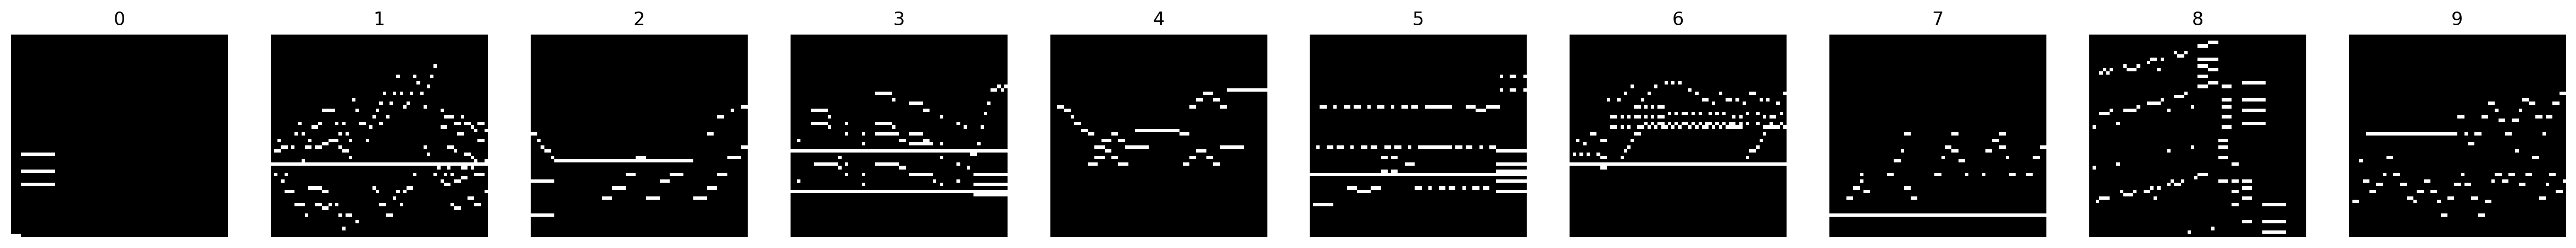

vae_input[0:10].shape :  (10, 64, 60, 1)
train_y[0:10] :  [0 0 3 3 3 2 3 3 0 1]


In [ ]:
num_sample = 10
vae_input = train_X[0:num_sample]
# vae_input = test_X[0:10]

jg_plot_rep_dane_wej(vae_input, 0 )
print("vae_input[0:10].shape : ", vae_input[0:num_sample].shape ) # vae.predict

print("train_y[0:10] : ", train_y[0:num_sample])

cond_num.shape:  (10, 1)
0 1 2 3 0 1 2 3 0 1 
condition_emo.shape:  (10, 4)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
../content/gen/Samples_10_images_1000_vae_rounded.png


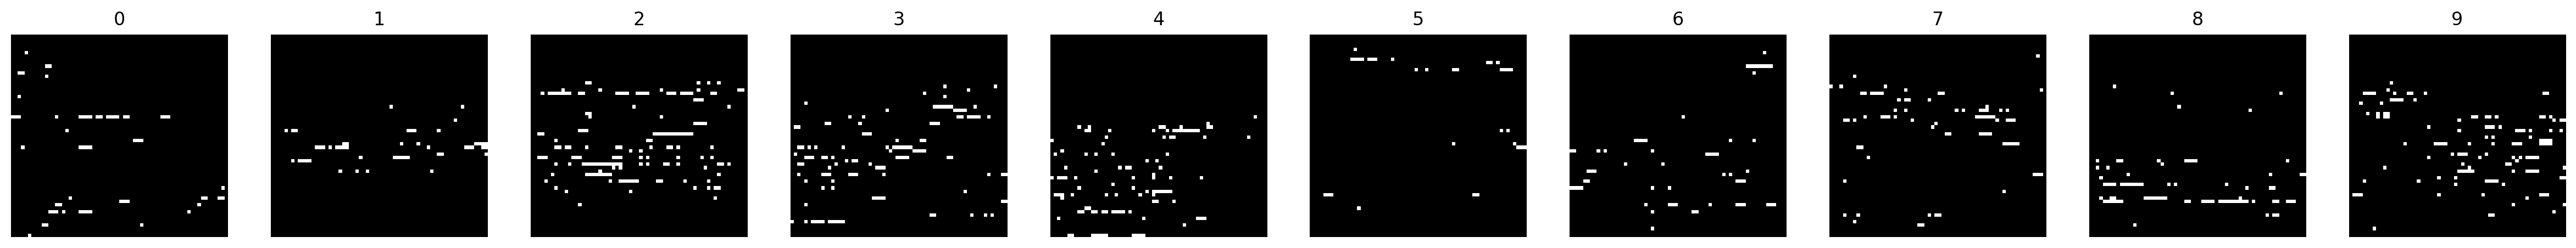

In [ ]:
a = jg_run_sampler(cvae, epoch, MODEL_CONFIG)

### Graj wej , graj wyj - Zapis output MIDI

### Generowanie condition_emo test

In [ ]:
num_sample = MODEL_CONFIG['num_sample']
latent_dim = MODEL_CONFIG['latent_dim']
z_sample = tf.random.normal(shape=(num_sample, latent_dim))
print("z_sample.shape: ", z_sample.shape)

condition_emo = jg_generate_labels(num_sample)

print('condition_emo: ', condition_emo)
print('condition_emo.shape: ', condition_emo.shape)

z_sample.shape:  (10, 32)
cond_num.shape:  (10, 1)
0 1 2 3 0 1 2 3 0 1 
condition_emo.shape:  (10, 4)
condition_emo:  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]
condition_emo.shape:  (10, 4)


## Generation new Emo seqence

In [ ]:
# ... existing code ...

import muspy

# Download the Bravura music font if not already downloaded
muspy.download_bravura_font()

# Function to generate sequence x_decoded_round with a given emotion emo={0, 1, 2, 3}
def jg_generate_seq_emo(emo):
    latent_dim = MODEL_CONFIG['latent_dim']
    num_sample = 1
    # Generate chords from randomly generated latent vector
    randomVec = np.random.normal(scale=1, size=(num_sample, latent_dim))
    print('randomVec.shape: ', randomVec.shape)

    cond_num = emo
    condition_emo = to_categorical(cond_num, 4).reshape(1, -1)
    print('condition_emo: ', condition_emo)
    print('condition_emo.shape: ', condition_emo.shape)

    x_decoded = cvae.decoder.predict([randomVec, condition_emo])
    x_decoded_round = x_decoded > 0.1
    print('x_decoded_round.shape: ', x_decoded_round.shape)
    return x_decoded_round

# Generate sequence with emotion 1
samples_emo_1 = jg_generate_seq_emo(0)
samples_pianoroll_emo_1 = jg_back_to_pianoroll(samples_emo_1)
my_music_emo_1 = muspy.from_pianoroll_representation(samples_pianoroll_emo_1[0], resolution=4, encode_velocity=False)
muspy.write_midi('../content/data/emo_1.mid', my_music_emo_1)
print("MIDI file saved as 'MIDI_epoch_1000_emo_1.mid'")

# Generate sequence with emotion 2
samples_emo_2 = jg_generate_seq_emo(1)
samples_pianoroll_emo_2 = jg_back_to_pianoroll(samples_emo_2)
my_music_emo_2 = muspy.from_pianoroll_representation(samples_pianoroll_emo_2[0], resolution=4, encode_velocity=False)
muspy.write_midi('../content/data/emo_2.mid', my_music_emo_2)
print("MIDI file saved as 'MIDI_epoch_1000_emo_2.mid'")

# Generate sequence with emotion 3
samples_emo_3 = jg_generate_seq_emo(2)
samples_pianoroll_emo_3 = jg_back_to_pianoroll(samples_emo_3)
my_music_emo_3 = muspy.from_pianoroll_representation(samples_pianoroll_emo_3[0], resolution=4, encode_velocity=False)
muspy.write_midi('../content/data/emo_3.mid', my_music_emo_3)
print("MIDI file saved as 'MIDI_epoch_1000_emo_3.mid'")

# Generate sequence with emotion 4
samples_emo_4 = jg_generate_seq_emo(3)
samples_pianoroll_emo_4 = jg_back_to_pianoroll(samples_emo_4)
my_music_emo_4 = muspy.from_pianoroll_representation(samples_pianoroll_emo_4[0], resolution=4, encode_velocity=False)
muspy.write_midi('../content/data/emo_4.mid', my_music_emo_4)
print("MIDI file saved as 'MIDI_epoch_1000_emo_4.mid'")

Skip downloading as the Bravura font is found.
randomVec.shape:  (1, 32)
condition_emo:  [[1. 0. 0. 0.]]
condition_emo.shape:  (1, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded_round.shape:  (1, 64, 60, 1)
samples:  (1, 64, 60, 1)
samples_pianoroll_rep.shape:  (1, 64, 128)
MIDI file saved as 'MIDI_epoch_1000_emo_1.mid'
randomVec.shape:  (1, 32)
condition_emo:  [[0. 1. 0. 0.]]
condition_emo.shape:  (1, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded_round.shape:  (1, 64, 60, 1)
samples:  (1, 64, 60, 1)
samples_pianoroll_rep.shape:  (1, 64, 128)
MIDI file saved as 'MIDI_epoch_1000_emo_2.mid'
randomVec.shape:  (1, 32)
condition_emo:  [[0. 0. 1. 0.]]
condition_emo.shape:  (1, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded_round.shape:  (1, 64, 60, 1)
samples:  (1, 64, 60, 1)
samples_pianoroll_rep.shape:  (1, 64, 128)
MIDI file saved as 'MIDI_epoch_1000_emo_3.mid'
randomVec.shape:  (1, 32)
condition_emo:  [[0. 0. 0. 1.]]
condition_emo.shape:  (1, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

## Generowanie zbiorów plikow seq do dir e1-e4

In [ ]:
import os
# liczba_plikow = 5
liczba_plikow = 20
emo = {0: 'e1', 1: 'e2', 2: 'e3', 3: 'e4'}
emo_arr = [0, 1, 2, 3]
gen_dir = '../content/data'

for j in range(len(emo)):
    directory = emo[j]
    path = os.path.join(gen_dir, directory)
    print("path: ", path)
    print("**********************************************************************")

    res = []
    for i in range(liczba_plikow):
        samples = jg_generate_seq_emo(emo_arr[j])
        samples_pianoroll =  jg_back_to_pianoroll(samples)
        my_new_music = muspy.from_pianoroll_representation (samples_pianoroll[0], resolution=4, encode_velocity=False)
#         my_new_music.show_score()
#         my_new_music.show_pianoroll()

        file_name = path + 'new_generated_'+ str(i)+ '.mid'
        muspy.write_midi(file_name, my_new_music)

        if hasattr(res, 'shape'):
            print("Jest shape")
            res = np.concatenate((res, samples_pianoroll), axis=0)
        else:
            print("Brak shape")
            res = samples_pianoroll

    print("res.shape: ", res.shape)

# score_matrix_mean = cvae.samples_metrics.eval(res, epoch, True)


path:  ../content/data/e1
**********************************************************************
randomVec.shape:  (1, 32)
condition_emo:  [[1. 0. 0. 0.]]
condition_emo.shape:  (1, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded_round.shape:  (1, 64, 60, 1)
samples:  (1, 64, 60, 1)
samples_pianoroll_rep.shape:  (1, 64, 128)
Brak shape
randomVec.shape:  (1, 32)
condition_emo:  [[1. 0. 0. 0.]]
condition_emo.shape:  (1, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded_round.shape:  (1, 64, 60, 1)
samples:  (1, 64, 60, 1)
samples_pianoroll_rep.shape:  (1, 64, 128)
Jest shape
randomVec.shape:  (1, 32)
condition_emo:  [[1. 0. 0. 0.]]
condition_emo.shape:  (1, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded_round.shape:  (1, 64, 60, 1)
samples:  (1, 64, 60, 1)
samples_pianoroll_rep.shape:  (1, 64, 128)
Jest shape
randomVec.shape:  (1, 32)
condition_emo:  [[1. 0. 0. 0.]]
condition_emo.shape:  (1, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded_round.shape:  (1, 64, 60, 1)
samples:  

In [ ]:
!zip -r /content/data.zip /content/data

updating: content/data/ (stored 0%)
updating: content/data/e2new_generated_14.mid (deflated 41%)
updating: content/data/e1new_generated_9.mid (deflated 42%)
updating: content/data/e1new_generated_5.mid (deflated 42%)
updating: content/data/e4new_generated_13.mid (deflated 47%)
updating: content/data/e3new_generated_9.mid (deflated 30%)
updating: content/data/e1new_generated_10.mid (deflated 44%)
updating: content/data/e3new_generated_13.mid (deflated 44%)
updating: content/data/e2new_generated_19.mid (deflated 34%)
updating: content/data/e1new_generated_19.mid (deflated 44%)
updating: content/data/e3new_generated_4.mid (deflated 47%)
updating: content/data/e1new_generated_6.mid (deflated 46%)
updating: content/data/e2new_generated_5.mid (deflated 44%)
updating: content/data/e4new_generated_14.mid (deflated 41%)
updating: content/data/e1new_generated_12.mid (deflated 45%)
updating: content/data/e1new_generated_2.mid (deflated 46%)
updating: content/data/e1new_generated_1.mid (deflated 3